<a href="https://colab.research.google.com/github/YossefMohamed/Detecting-COVID-19-Through-Sound/blob/main/firstDLmodel(after%20Augmentation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from sklearn.metrics import roc_curve
from keras.utils import np_utils
from tqdm import tqdm
import pandas as pd
import numpy as np
import librosa 
import librosa.display
import pylab
import cv2
import os

---
# 1-Prepare Data
---



**DOWNLOAD DATA**

In [2]:
!git clone https://github.com/iiscleap/Coswara-Data.git

Cloning into 'Coswara-Data'...
remote: Enumerating objects: 798, done.
remote: Total 798 (delta 0), reused 0 (delta 0), pack-reused 798
Receiving objects: 100% (798/798), 15.97 GiB | 26.41 MiB/s, done.
Resolving deltas: 100% (310/310), done.
Checking out files: 100% (202/202), done.


In [4]:
rt_dir = '/content/Coswara-Data'
import glob
for each in os.listdir(rt_dir):
    if os.path.isdir(os.path.join(rt_dir,each)) and each != '.git':
        print(each)
        !cat {os.path.join(rt_dir, each,'')}*.tar.gz.* > {os.path.join(rt_dir, each,'')}combined_file.tar.gz
        !tar -xzf {os.path.join(rt_dir, each,'')}combined_file.tar.gz -C {rt_dir}
subset = glob.glob('/content/Coswara-Data/*/*.tar.gz.*') + glob.glob('/content/Coswara-Data/*/combined_data.tar.gz')
[os.remove(x) for x in subset];

20210206
cat: '/content/Coswara-Data/20210206/*.tar.gz.*': No such file or directory

gzip: stdin: unexpected end of file
tar: Child returned status 1
tar: Error is not recoverable: exiting now
20200505
cat: '/content/Coswara-Data/20200505/*.tar.gz.*': No such file or directory

gzip: stdin: unexpected end of file
tar: Child returned status 1
tar: Error is not recoverable: exiting now
20200415
cat: '/content/Coswara-Data/20200415/*.tar.gz.*': No such file or directory

gzip: stdin: unexpected end of file
tar: Child returned status 1
tar: Error is not recoverable: exiting now
20210603
cat: '/content/Coswara-Data/20210603/*.tar.gz.*': No such file or directory

gzip: stdin: unexpected end of file
tar: Child returned status 1
tar: Error is not recoverable: exiting now
20200911
cat: '/content/Coswara-Data/20200911/*.tar.gz.*': No such file or directory

gzip: stdin: unexpected end of file
tar: Child returned status 1
tar: Error is not recoverable: exiting now
20200901
cat: '/content/Coswar

In [5]:
import glob
names   = ['ID','Fever/MP','ORC','STATUS','DIR','DataSet']
join_by = pd.read_csv('/content/Coswara-Data/combined_data.csv')

df_list = []
for path in tqdm(glob.glob('/content/Coswara-Data/*/*/cough-shallow.wav')):
  temp = pd.DataFrame(columns=['id','DIR'])
  temp['id'] = [path.split('/')[-2]]
  temp['DIR'] = [path]
  temp = pd.merge(left=temp,right=join_by,on='id',how='inner')

  temp['fomp']= (temp['fever']| temp['mp']).apply(int)
  temp['oths']= (temp['cld']|temp['asthma']|temp['cold']|temp['st']|temp['pneumonia']).apply(int)
  temp        = temp[['id','covid_status','DIR','fomp','oths']]
  df_list.append(temp.rename(columns={'id':'ID','covid_status':'STATUS','DIR':'DIR','fomp':'Fever/MP','oths':'ORC'}))
CosData=pd.concat(df_list)
CosData['DataSet'] = 'coswara'


100%|██████████| 2745/2745 [00:30<00:00, 91.43it/s]


In [6]:
!wget https://zenodo.org/record/4048312/files/public_dataset.zip?download=1
!mv public_dataset.zip?download=1 public_dataset.zip
!unzip -q public_dataset.zip
!mkdir 'custom_dataset'

--2022-03-02 19:59:40--  https://zenodo.org/record/4048312/files/public_dataset.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 951442487 (907M) [application/octet-stream]
Saving to: ‘public_dataset.zip?download=1’

public_dataset.zip? 100%[===================>] 907.37M  26.7MB/s    in 20s     

2022-03-02 20:00:01 (44.7 MB/s) - ‘public_dataset.zip?download=1’ saved [951442487/951442487]



In [7]:
from google.colab import data_table
data_table.DataTable(CosData)

,ID,STATUS,DIR,Fever/MP,ORC,DataSet
0,CU6Sqlt8NfMboou9neSzsyNLyKD2,healthy,/content/Coswara-Data/20210206/CU6Sqlt8NfMboou...,0,1,coswara
0,Bb9OMQWb3GNbJDH4gANBkWJ4Ihs1,healthy,/content/Coswara-Data/20210206/Bb9OMQWb3GNbJDH...,0,0,coswara
0,smnOOz3onPU2GxyyQuwVJuiU0No1,healthy,/content/Coswara-Data/20210206/smnOOz3onPU2Gxy...,0,0,coswara
0,yL9QW3T2VueXfL3yvsmXsM2hL4v1,positive_mild,/content/Coswara-Data/20210206/yL9QW3T2VueXfL3...,0,1,coswara
0,KYFep4QYHeTdetDl8dhMl0je3ux1,healthy,/content/Coswara-Data/20210206/KYFep4QYHeTdetD...,0,0,coswara
...,...,...,...,...,...,...
0,Xn3y4lqypTNVBsB1yYYkDDypizk2,recovered_full,/content/Coswara-Data/20210426/Xn3y4lqypTNVBsB...,0,0,coswara
0,w5duFqV8D8V8c0hZLdmvSkmgcmz1,no_resp_illness_exposed,/content/Coswara-Data/20210426/w5duFqV8D8V8c0h...,0,0,coswara
0,hB8ntHij4nOm6YoGj86MtZJVTyr2,healthy,/content/Coswara-Data/20210426/hB8ntHij4nOm6Yo...,0,0,coswara
0,R2GSpbi6GQWiCzz17TR8yj4UB4a2,no_resp_illness_exposed,/content/Coswara-Data/20210426/R2GSpbi6GQWiCzz...,0,0,coswara


In [8]:
CosData['STATUS'].unique()

array(['healthy', 'positive_mild', 'no_resp_illness_exposed',
       'recovered_full', 'resp_illness_not_identified', 'positive_asymp',
       'positive_moderate', 'under_validation'], dtype=object)

In [9]:
positive_mild = CosData.loc[CosData['STATUS']=='positive_mild']
positive_moderate	 = CosData.loc[CosData['STATUS']=='positive_moderate']
positive_asymp = CosData.loc[CosData['STATUS']=='positive_asymp']

coswara_positive = pd.concat([positive_mild,positive_moderate,positive_asymp])

healthy = CosData.loc[CosData['STATUS']=='healthy']
resp_illness_not_identified = CosData.loc[CosData['STATUS']=='resp_illness_not_identified']
no_resp_illness_exposed = CosData.loc[CosData['STATUS']=='no_resp_illness_exposed']
recovered_full = CosData.loc[CosData['STATUS']=='recovered_full']

negative =  pd.concat([healthy,resp_illness_not_identified,no_resp_illness_exposed,recovered_full])

print(len(coswara_positive))
print(len(negative))
f_negative = negative.loc[negative['STATUS']!='COVID-19'][0:1000]
print(len(f_negative))



681
1983
1000


In [10]:
del(negative)

In [11]:
data_table.DataTable(f_negative )

,ID,STATUS,DIR,Fever/MP,ORC,DataSet
0,CU6Sqlt8NfMboou9neSzsyNLyKD2,healthy,/content/Coswara-Data/20210206/CU6Sqlt8NfMboou...,0,1,coswara
0,Bb9OMQWb3GNbJDH4gANBkWJ4Ihs1,healthy,/content/Coswara-Data/20210206/Bb9OMQWb3GNbJDH...,0,0,coswara
0,smnOOz3onPU2GxyyQuwVJuiU0No1,healthy,/content/Coswara-Data/20210206/smnOOz3onPU2Gxy...,0,0,coswara
0,KYFep4QYHeTdetDl8dhMl0je3ux1,healthy,/content/Coswara-Data/20210206/KYFep4QYHeTdetD...,0,0,coswara
0,D5aq6FUMeCQal79ePD7UZniIyF12,healthy,/content/Coswara-Data/20210206/D5aq6FUMeCQal79...,0,0,coswara
...,...,...,...,...,...,...
0,c96Fr87Qw8cbz2JKR4yE6DiuSrq1,healthy,/content/Coswara-Data/20210816/c96Fr87Qw8cbz2J...,0,0,coswara
0,XAQ5xkTIEHXSPX6q02PJ6WvPNuD3,healthy,/content/Coswara-Data/20210816/XAQ5xkTIEHXSPX6...,0,0,coswara
0,hbLP3s7RLsTgaMSRNWkIuuggpyL2,healthy,/content/Coswara-Data/20210816/hbLP3s7RLsTgaMS...,0,0,coswara
0,WcRpZenx0WWQmzOUPTHEEGlyJAg1,healthy,/content/Coswara-Data/20210816/WcRpZenx0WWQmzO...,0,0,coswara


## COUGHVID

In [12]:
coughvid  = '/content/public_dataset/'
custpath  = '/content/custom_dataset/' #Where mel spec images will be stored

VidData   = pd.read_csv(os.path.join(coughvid,'metadata_compiled.csv'),header=0)
VidData   = VidData.loc[VidData['cough_detected'] >= 0.9][['uuid','fever_muscle_pain','respiratory_condition','status']]
VidData.dropna(inplace=True)

coughvid_positive = VidData.loc[VidData['status']=='COVID-19']
coughvid_negative = VidData.loc[VidData['status']!='COVID-19'] [0:1200]


In [13]:
len(coughvid_negative)

1200

In [14]:
VidData['status'].unique()

array(['healthy', 'symptomatic', 'COVID-19'], dtype=object)

In [ ]:

TotData   = pd.concat([coughvid_positive,coughvid_negative],ignore_index= True)
TotData['DIR'] = coughvid + TotData['uuid'] + '.webm'
TotData['DataSet'] = 'coughvid'
TotData['fever_muscle_pain']    = TotData['fever_muscle_pain'].apply(int)
TotData['respiratory_condition']= TotData['respiratory_condition'].apply(int)
TotData   = pd.concat([CosData,TotData.rename(columns={'uuid':'ID','status':'STATUS','fever_muscle_pain':'Fever/MP','respiratory_condition':'ORC'})])
TotData   = TotData.sample(frac=1).reset_index(drop=True)

In [ ]:

coughvid_positive['DIR'] = coughvid + coughvid_positive['uuid'] + '.webm'
coughvid_positive['DataSet'] = 'coughvid'
coughvid_positive['fever_muscle_pain']    = coughvid_positive['fever_muscle_pain'].apply(int)
coughvid_positive['respiratory_condition']= coughvid_positive['respiratory_condition'].apply(int)
coughvid_positive =coughvid_positive.rename(columns={'uuid':'ID','status':'STATUS','fever_muscle_pain':'Fever/MP','respiratory_condition':'ORC'})
coughvid_positive  = coughvid_positive.sample(frac=1).reset_index(drop=True)

In [16]:

coughvid_negative['DIR'] = coughvid + coughvid_negative['uuid'] + '.webm'
coughvid_negative['DataSet'] = 'coughvid'
coughvid_negative['fever_muscle_pain']    = coughvid_negative['fever_muscle_pain'].apply(int)
coughvid_negative['respiratory_condition']= coughvid_negative['respiratory_condition'].apply(int)
coughvid_negative =coughvid_negative.rename(columns={'uuid':'ID','status':'STATUS','fever_muscle_pain':'Fever/MP','respiratory_condition':'ORC'})
coughvid_negative = coughvid_negative.sample(frac=1).reset_index(drop=True)

In [ ]:
data_table.DataTable(TotData )

In [18]:
data_table.DataTable(coughvid_positive )

,ID,Fever/MP,ORC,STATUS,DIR,DataSet
0,5418a808-f17d-4985-a1eb-5d1ee3647cb0,0,0,COVID-19,/content/public_dataset/5418a808-f17d-4985-a1e...,coughvid
1,309f7a85-57c3-4b1f-baa9-d1290d1d1b23,0,0,COVID-19,/content/public_dataset/309f7a85-57c3-4b1f-baa...,coughvid
2,18e49b6e-60e4-4eb1-8de8-e8261576dbfc,0,0,COVID-19,/content/public_dataset/18e49b6e-60e4-4eb1-8de...,coughvid
3,774bafb8-5d1c-42c5-a0a8-91ba0a85a04b,1,0,COVID-19,/content/public_dataset/774bafb8-5d1c-42c5-a0a...,coughvid
4,49bc7b95-fbe5-4933-886e-8752b8acf842,0,0,COVID-19,/content/public_dataset/49bc7b95-fbe5-4933-886...,coughvid
...,...,...,...,...,...,...
436,b9e06a23-d76b-4164-b39a-64cd753a3c56,0,0,COVID-19,/content/public_dataset/b9e06a23-d76b-4164-b39...,coughvid
437,bf7f0dd3-eaef-4912-8edc-c919fd98df62,0,1,COVID-19,/content/public_dataset/bf7f0dd3-eaef-4912-8ed...,coughvid
438,e18efb30-aea1-4cf9-aadb-0afe4c51c7df,0,1,COVID-19,/content/public_dataset/e18efb30-aea1-4cf9-aad...,coughvid
439,d5c506d9-9b17-4886-b5b3-999f8ee8060a,0,0,COVID-19,/content/public_dataset/d5c506d9-9b17-4886-b5b...,coughvid


# 2-Data Augmentaion

In [19]:
!pip install audiomentations

     |████████████████████████████████| 60 kB 4.8 MB/s 


In [20]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import soundfile as sf
import librosa

In [21]:
!mkdir augmented_data
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])

In [22]:
aug_coswara_positive = pd.DataFrame()
for audio_file in  tqdm(coswara_positive["DIR"]):
  try:
    samples, sr = librosa.load(audio_file)
    augmented_sample = augment(samples=samples, sample_rate=sr)
    sf.write("/content/augmented_data/" + audio_file.split("/")[-2] + ".wav", augmented_sample, sr) #write with wav extantion

    aug_coswara_positive = aug_coswara_positive.append(coswara_positive.loc[coswara_positive['ID'] == audio_file.split("/")[-2]])
    aug_coswara_positive["DIR"].replace({ audio_file : "/content/augmented_data/" + audio_file.split("/")[-2] + ".wav"}, inplace=True)
    aug_coswara_positive["ID"].replace({ audio_file.split("/")[-2] :  audio_file.split("/")[-2] + "AUG"}, inplace=True)

  except:
    print("\n File Not Found :))")

 59%|█████▉    | 405/681 [02:39<01:06,  4.13it/s]


 File Not Found :))


 81%|████████  | 552/681 [03:32<01:01,  2.09it/s]


 File Not Found :))


 96%|█████████▌| 654/681 [04:07<00:10,  2.50it/s]


 File Not Found :))


100%|██████████| 681/681 [04:19<00:00,  2.62it/s]


In [23]:
len(aug_coswara_positive)

678

In [24]:
aug_coughvid_positive = pd.DataFrame()

for audio_file in  tqdm(coughvid_positive["DIR"]):
  try:
    samples, sr = librosa.load(audio_file)
    augmented_sample = augment(samples=samples, sample_rate=sr)
    sf.write("/content/augmented_data/" + audio_file.split("/")[-1][0:-5] + ".wav", augmented_sample, sr) #write with wav extantion

    aug_coughvid_positive = aug_coughvid_positive.append(coughvid_positive.loc[coughvid_positive['ID'] == audio_file.split("/")[-1][0:-5]])
    aug_coughvid_positive["DIR"].replace({"/content/augmented_data/"+ audio_file.split("/")[-1][0:-5] + ".webm": "/content/augmented_data/" + audio_file.split("/")[-1][0:-5] + ".wav"}, inplace=True)
    aug_coughvid_positive["ID"].replace({ audio_file.split("/")[-1][0:-5] :  audio_file.split("/")[-1][0:-5] + "AUG"}, inplace=True)

  except:
    print("\n File cannot open)")

  0%|          | 0/441 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 1/441 [00:02<17:21,  2.37s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 2/441 [00:03<11:40,  1.59s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 3/441 [00:04<09:14,  1.27s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 4/441 [00:05<07:41,  1.06s/it]/usr/local/li


 File cannot open)


  4%|▍         | 17/441 [00:15<04:53,  1.44it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 18/441 [00:16<05:14,  1.35it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  4%|▍         | 19/441 [00:17<05:24,  1.30it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▍         | 20/441 [00:18<05:32,  1.27it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▍         | 21/441 [00:19<05:33,  1.26it/s]


 File cannot open)


 29%|██▉       | 127/441 [01:51<03:51,  1.35it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 128/441 [01:52<03:56,  1.33it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 129/441 [01:53<04:11,  1.24it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 130/441 [01:54<04:34,  1.13it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 131/441 [01:54<04:23,  1.18


 File cannot open)


 49%|████▉     | 218/441 [03:06<02:44,  1.35it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 50%|████▉     | 219/441 [03:07<03:04,  1.20it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 50%|████▉     | 220/441 [03:07<02:18,  1.60it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")



 File cannot open)


 50%|█████     | 221/441 [03:08<02:22,  1.54it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 50%|█████     | 222/441 [03:09<02:55,  1.25it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████     | 223/441 [03:10<03:13,  1.13it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████     | 224/441 [03:11<03:02,  1.19it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████     | 225/441 [03:11<02:33,  1.41


 File cannot open)


 59%|█████▉    | 260/441 [03:39<01:57,  1.53it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 59%|█████▉    | 261/441 [03:40<02:23,  1.25it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 59%|█████▉    | 262/441 [03:41<02:35,  1.15it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 60%|█████▉    | 263/441 [03:42<02:48,  1.06it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 60%|█████▉    | 264/441 [03:43<03:02,  1.03


 File cannot open)


 73%|███████▎  | 321/441 [04:29<01:07,  1.77it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 73%|███████▎  | 322/441 [04:30<01:17,  1.53it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 73%|███████▎  | 323/441 [04:31<01:19,  1.49it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 73%|███████▎  | 324/441 [04:32<01:20,  1.45it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 74%|███████▎  | 325/441 [04:32<01:20,  1.43


 File cannot open)


 78%|███████▊  | 344/441 [04:49<01:16,  1.27it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 78%|███████▊  | 345/441 [04:49<01:07,  1.42it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 78%|███████▊  | 346/441 [04:50<01:10,  1.35it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 79%|███████▊  | 347/441 [04:51<01:20,  1.17it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 79%|███████▉  | 348/441 [04:52<01:12,  1.27

In [25]:
print(len(coswara_positive))
print(len(coughvid_positive))
print(len(aug_coughvid_positive ))
print(len(aug_coswara_positive ))

681
441
434
678


#spilt to train - test - validation


In [26]:

coughvid_positive_train = coughvid_positive[:int(0.8*len(coughvid_positive))]  
coughvid_positive_test = coughvid_positive[ int(0.8*len(coughvid_positive)): int(0.9*len(coughvid_positive))]  
coughvid_positive_val = coughvid_positive[ int(0.9*len(coughvid_positive)) :]


coughvid_negative_train = coughvid_negative[:int(0.8*len(coughvid_negative))]  
coughvid_negative_test = coughvid_negative[ int(0.8*len(coughvid_negative)): int(0.9*len(coughvid_negative))]
coughvid_negative_val = coughvid_negative[ int(0.9*len(coughvid_negative)) :]

aug_covid_samples_train = aug_coughvid_positive[:int(0.8*len(aug_coughvid_positive))]  
aug_covid_samples_test = aug_coughvid_positive[ int(0.8*len(aug_coughvid_positive)): int(0.9*len(aug_coughvid_positive))]
aug_covid_samples_val = aug_coughvid_positive[ int(0.9*len(aug_coughvid_positive)) :]



aug_positive_samples_train = aug_coswara_positive[:int(0.8*len(aug_coswara_positive))]  
aug_positive_samples_test = aug_coswara_positive[ int(0.8*len(aug_coswara_positive)): int(0.9*len(aug_coswara_positive))]
aug_positive_samples_val = aug_coswara_positive[ int(0.9*len(aug_coswara_positive)) :]



coswara_positive_samples_train = coswara_positive[:int(0.8*len(coswara_positive))]    
coswara_positive_samples_test = coswara_positive[ int(0.8*len(coswara_positive)): int(0.9*len(coswara_positive))]
coswara_positive_samples_val = coswara_positive[ int(0.9*len(coswara_positive)) :]


negative_samples_train = f_negative[:int(0.8*len(f_negative))]    
negative_samples_test = f_negative[ int(0.8*len(f_negative)): int(0.9*len(f_negative))]
negattive_samples_val = f_negative[ int(0.9*len(f_negative)) :]


In [27]:
#train Data
train = [coughvid_positive_train,coughvid_negative_train,aug_positive_samples_train,aug_positive_samples_train,coswara_positive_samples_train,negative_samples_train]
Data_train = pd.concat(train)


# validation Data
val =[coughvid_positive_val,coughvid_negative_val,aug_positive_samples_val,aug_positive_samples_val,coswara_positive_samples_val,negattive_samples_val]
Data_val = pd.concat(val)

# test Data
test = [coughvid_positive_test,coughvid_negative_test,aug_positive_samples_test,aug_positive_samples_test,coswara_positive_samples_test,negative_samples_test]
Data_test = pd.concat(test)
print(len(Data_train) , len(Data_val) , len(Data_test))

3740 470 468






## Feature Extraction

In [28]:
def feature_extractor(row):

  name     = row[-6]
  try:
    audio,sr = librosa.load(row[-2])
    #For MFCCS 
    mfccs    = librosa.feature.mfcc(y=audio,sr=22050, n_mfcc=39)
    mfccsscaled = np.mean(mfccs.T,axis=0)
    
    #Mel Spectogram
    pylab.axis('off') # no axis
    pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
    melspec  = librosa.feature.melspectrogram(y=audio,sr=sr)
    s_db     = librosa.power_to_db(melspec, ref=np.max)
    librosa.display.specshow(s_db)

    savepath = os.path.join(custpath,name+'.png')
    pylab.savefig(savepath, bbox_inches=None, pad_inches=0)
    pylab.close()
  except:
    print('File cannot open')
    return None,None
   # return mfccsscaled

  return mfccsscaled,savepath

#train
features_train = []
diagnoses_train= []
imgpaths_train = []
#validation
features_val = []
diagnoses_val= []
imgpaths_val = []
#test
features_test = []
diagnoses_test= []
imgpaths_test = []

In [29]:
# train
for row in tqdm(Data_train.values):
  mfccs,savepath  = feature_extractor(row)
  features_train.append(mfccs)
  imgpaths_train.append(savepath)
  diagnoses_train.append([row[-5],row[-4]])

  0%|          | 0/3740 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 1/3740 [00:00<1:01:06,  1.02it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 2/3740 [00:01<59:30,  1.05it/s]  /usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 3/3740 [00:02<59:22,  1.05it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 4/3740 [00:03<58:18,  1.07it/s]/usr

File cannot open


  0%|          | 17/3740 [00:14<44:29,  1.39it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 18/3740 [00:15<46:33,  1.33it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 19/3740 [00:16<50:03,  1.24it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 20/3740 [00:17<52:51,  1.17it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 21/3740 [00:18<54:22,  1.14

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 127/3740 [01:52<48:16,  1.25it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 128/3740 [01:53<51:25,  1.17it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 129/3740 [01:54<52:49,  1.14it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 130/3740 [01:55<55:25,  1.09it/s]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 218/3740 [03:18<50:56,  1.15it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 219/3740 [03:19<54:26,  1.08it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 220/3740 [03:20<42:32,  1.38it/s]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 221/3740 [03:20<43:24,  1.35it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 222/3740 [03:21<49:06,  1.19it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 223/3740 [03:22<53:22,  1.10it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 224/3740 [03:23<56:07,  1.04it/s]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 260/3740 [03:59<51:54,  1.12it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 261/3740 [04:00<55:58,  1.04it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 262/3740 [04:01<58:21,  1.01s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 263/3740 [04:02<1:00:00,  1.04s/it]/usr/local/lib/python3.7/dist-packages

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▊         | 321/3740 [05:09<46:48,  1.22it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▊         | 322/3740 [05:10<52:04,  1.09it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▊         | 323/3740 [05:11<55:56,  1.02it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▊         | 324/3740 [05:12<58:26,  1.03s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 344/3740 [05:33<51:00,  1.11it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 345/3740 [05:34<51:04,  1.11it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 346/3740 [05:35<55:02,  1.03it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 347/3740 [05:36<58:18,  1.03s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|▉         | 359/3740 [05:49<54:21,  1.04it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|▉         | 360/3740 [05:50<57:37,  1.02s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|▉         | 361/3740 [05:52<1:00:18,  1.07s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|▉         | 362/3740 [05:53<58:24,  1.04s/it]  /usr/local/lib/python3.7/dist-packag

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|▉         | 370/3740 [06:00<44:39,  1.26it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|▉         | 371/3740 [06:01<50:55,  1.10it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|▉         | 372/3740 [06:02<55:27,  1.01it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|▉         | 373/3740 [06:03<58:18,  1.04s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 438/3740 [07:12<53:59,  1.02it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 439/3740 [07:13<54:28,  1.01it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 440/3740 [07:15<58:02,  1.06s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 441/3740 [07:16<1:00:44,  1.10s/it]/usr/local/lib/python3.7/dist-packages

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 449/3740 [07:24<55:06,  1.00s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 450/3740 [07:25<58:38,  1.07s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 451/3740 [07:27<1:00:46,  1.11s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 452/3740 [07:28<58:59,  1.08s/it]  /usr/local/lib/python3.7/dist-packag

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 476/3740 [07:53<52:46,  1.03it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 477/3740 [07:55<55:30,  1.02s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 478/3740 [07:57<1:09:34,  1.28s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 479/3740 [07:58<1:07:58,  1.25s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 485/3740 [08:04<53:29,  1.01it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 486/3740 [08:05<57:42,  1.06s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 487/3740 [08:06<58:32,  1.08s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 13%|█▎        | 488/3740 [08:07<1:00:59,  1.13s/it]/usr/local/lib/python3.7/dist-packages

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 524/3740 [08:47<54:25,  1.02s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 525/3740 [08:48<53:10,  1.01it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 526/3740 [08:49<55:22,  1.03s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 527/3740 [08:50<59:15,  1.11s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 536/3740 [09:00<57:18,  1.07s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 537/3740 [09:02<1:00:39,  1.14s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 538/3740 [09:03<1:00:44,  1.14s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▍        | 539/3740 [09:04<1:02:23,  1.17s/it]/usr/local/lib/python3.7/dist-pack

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 543/3740 [09:08<56:55,  1.07s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 544/3740 [09:09<1:00:16,  1.13s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 545/3740 [09:10<58:15,  1.09s/it]  /usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 546/3740 [09:12<1:00:59,  1.15s/it]/usr/local/lib/python3.7/dist-pack

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 605/3740 [10:19<54:17,  1.04s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 606/3740 [10:20<54:36,  1.05s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 607/3740 [10:21<58:40,  1.12s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▋        | 608/3740 [10:22<1:01:31,  1.18s/it]/usr/local/lib/python3.7/dist-packages

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 627/3740 [10:45<56:33,  1.09s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 628/3740 [10:46<57:27,  1.11s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 629/3740 [10:47<1:00:19,  1.16s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 630/3740 [10:48<57:20,  1.11s/it]  /usr/local/lib/python3.7/dist-packag

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 639/3740 [10:59<55:16,  1.07s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 640/3740 [10:59<45:42,  1.13it/s]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 641/3740 [11:01<1:03:13,  1.22s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 642/3740 [11:02<1:02:00,  1.20s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 643/3740 [11:03<1:00:09,  1.17s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 644/3740 [11:05<1:02:34,  1.21s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 655/3740 [11:18<51:40,  1.01s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 656/3740 [11:19<56:35,  1.10s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 657/3740 [11:20<1:00:12,  1.17s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 658/3740 [11:22<1:02:27,  1.22s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 663/3740 [11:27<57:00,  1.11s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 664/3740 [11:28<57:46,  1.13s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 665/3740 [11:30<1:00:40,  1.18s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 666/3740 [11:31<1:03:00,  1.23s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|██        | 764/3740 [13:32<58:45,  1.18s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|██        | 765/3740 [13:33<59:22,  1.20s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|██        | 766/3740 [13:34<1:00:01,  1.21s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 767/3740 [13:36<59:36,  1.20s/it]  /usr/local/lib/python3.7/dist-packag

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 784/3740 [13:56<53:01,  1.08s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 785/3740 [13:58<57:26,  1.17s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 786/3740 [13:59<54:39,  1.11s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 787/3740 [14:00<58:29,  1.19s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 846/3740 [15:24<54:38,  1.13s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 847/3740 [15:26<59:09,  1.23s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 848/3740 [15:27<1:02:39,  1.30s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 849/3740 [15:28<52:00,  1.08s/it]  

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 850/3740 [15:29<58:03,  1.21s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 851/3740 [15:31<1:01:18,  1.27s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 852/3740 [15:32<1:03:49,  1.33s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 853/3740 [15:34<1:05:34,  1.36s/it]/usr/local/lib/python3.7/dist-pack

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 856/3740 [15:37<56:30,  1.18s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 857/3740 [15:38<57:34,  1.20s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 858/3740 [15:40<1:01:22,  1.28s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 859/3740 [15:41<1:03:43,  1.33s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 925/3740 [17:12<58:01,  1.24s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 926/3740 [17:13<56:04,  1.20s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 927/3740 [17:15<1:00:11,  1.28s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 928/3740 [17:16<1:03:02,  1.35s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 935/3740 [17:24<46:42,  1.00it/s]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 936/3740 [17:26<48:35,  1.04s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 937/3740 [17:27<54:58,  1.18s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 938/3740 [17:28<55:27,  1.19s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 939/3740 [17:29<47:24,  1.02s/it]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 940/3740 [17:30<54:38,  1.17s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 941/3740 [17:32<59:26,  1.27s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 942/3740 [17:33<1:02:36,  1.34s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 943/3740 [17:35<1:02:31,  1.34s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 1000/3740 [19:00<57:56,  1.27s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 1001/3740 [19:01<1:01:52,  1.36s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 1002/3740 [19:03<1:04:21,  1.41s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 1003/3740 [19:04<1:03:37,  1.39s/it]/usr/local/lib/python3.7/dist-

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 1024/3740 [19:34<1:00:23,  1.33s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 1025/3740 [19:35<1:03:09,  1.40s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 1026/3740 [19:37<1:05:32,  1.45s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 1027/3740 [19:38<1:04:00,  1.42s/it]/usr/local/lib/python3.7/dis

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 1061/3740 [20:26<56:03,  1.26s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 1062/3740 [20:27<59:12,  1.33s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 1063/3740 [20:29<1:02:20,  1.40s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 1064/3740 [20:30<1:01:39,  1.38s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 1086/3740 [21:01<56:40,  1.28s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 1087/3740 [21:03<1:00:38,  1.37s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 1088/3740 [21:05<1:03:26,  1.44s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 1089/3740 [21:08<1:30:49,  2.06s/it]/usr/local/lib/python3.7/dist-

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 1130/3740 [22:07<58:20,  1.34s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 1131/3740 [22:09<57:48,  1.33s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 1132/3740 [22:10<1:00:19,  1.39s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 1133/3740 [22:12<1:03:26,  1.46s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 1150/3740 [22:37<56:18,  1.30s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 1151/3740 [22:38<1:00:21,  1.40s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 1152/3740 [22:40<1:02:43,  1.45s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 1153/3740 [22:41<1:05:14,  1.51s/it]/usr/local/lib/python3.7/dist-

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1181/3740 [23:24<59:47,  1.40s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1182/3740 [23:25<59:58,  1.41s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1183/3740 [23:26<58:49,  1.38s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1184/3740 [23:28<56:25,  1.32s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▎      | 1258/3740 [25:28<59:52,  1.45s/it]  /usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▎      | 1259/3740 [25:29<59:46,  1.45s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▎      | 1260/3740 [25:31<1:02:42,  1.52s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▎      | 1261/3740 [25:33<1:04:39,  1.56s/it]/usr/local/lib/python3.7/dist-

File cannot open


 81%|████████  | 3025/3740 [35:03<04:29,  2.65it/s]

File cannot open


 83%|████████▎ | 3112/3740 [35:45<05:03,  2.07it/s]

File cannot open


 84%|████████▍ | 3142/3740 [35:57<03:44,  2.66it/s]

File cannot open


 85%|████████▍ | 3162/3740 [36:06<04:51,  1.98it/s]

File cannot open


 85%|████████▌ | 3180/3740 [36:14<04:44,  1.97it/s]

File cannot open


 86%|████████▌ | 3198/3740 [36:22<04:06,  2.20it/s]

File cannot open


 86%|████████▌ | 3220/3740 [36:32<03:55,  2.20it/s]

File cannot open


 88%|████████▊ | 3275/3740 [36:56<03:09,  2.45it/s]

File cannot open


 94%|█████████▍| 3518/3740 [38:48<02:15,  1.64it/s]

File cannot open


 94%|█████████▍| 3532/3740 [38:53<01:22,  2.53it/s]

File cannot open


 95%|█████████▌| 3553/3740 [39:02<01:09,  2.71it/s]

File cannot open


 96%|█████████▌| 3573/3740 [39:15<02:18,  1.20it/s]

File cannot open


 96%|█████████▌| 3584/3740 [39:19<01:04,  2.43it/s]

File cannot open


 97%|█████████▋| 3619/3740 [39:35<00:54,  2.22it/s]

File cannot open


 97%|█████████▋| 3633/3740 [39:40<00:48,  2.18it/s]

File cannot open


 98%|█████████▊| 3673/3740 [39:59<00:29,  2.29it/s]

File cannot open


 99%|█████████▉| 3695/3740 [40:09<00:18,  2.47it/s]

File cannot open
File cannot open


100%|██████████| 3740/3740 [40:29<00:00,  1.54it/s]


In [30]:
#validation
for row in tqdm(Data_val.values):
  mfccs,savepath  = feature_extractor(row)
  features_val.append(mfccs)
  imgpaths_val.append(savepath)
  diagnoses_val.append([row[-5],row[-4]])

  0%|          | 0/470 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 1/470 [00:02<21:44,  2.78s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 2/470 [00:05<21:04,  2.70s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 3/470 [00:08<20:52,  2.68s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 4/470 [00:10<20:51,  2.69s/it]/usr/local/li

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 50/470 [02:10<17:05,  2.44s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 51/470 [02:12<17:38,  2.53s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 52/470 [02:15<17:55,  2.57s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█▏        | 53/470 [02:18<18:10,  2.61s/it]/usr/local/lib/python3.7/dist-packages/librosa/c

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 130/470 [05:40<13:31,  2.39s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 131/470 [05:43<14:04,  2.49s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 132/470 [05:46<14:19,  2.54s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 133/470 [05:48<14:16,  2.54s/it]/usr/local/lib/python3.7/dist-packages/libro

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▊       | 135/470 [05:53<13:25,  2.40s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 136/470 [05:55<13:57,  2.51s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 137/470 [05:58<14:16,  2.57s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 138/470 [06:00<13:55,  2.52s/it]/usr/local/lib/python3.7/dist-packages/libro

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 142/470 [06:10<13:00,  2.38s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|███       | 143/470 [06:13<13:36,  2.50s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 144/470 [06:15<13:25,  2.47s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 31%|███       | 145/470 [06:18<13:51,  2.56s/it]/usr/local/lib/python3.7/dist-packages/libro

File cannot open


 80%|███████▉  | 374/470 [08:10<00:57,  1.67it/s]

File cannot open


100%|█████████▉| 468/470 [08:50<00:00,  2.24it/s]

File cannot open


100%|██████████| 470/470 [08:51<00:00,  1.13s/it]


In [31]:
#test
for row in tqdm(Data_test.values):
  mfccs,savepath  = feature_extractor(row)
  features_test.append(mfccs)
  imgpaths_test.append(savepath)
  diagnoses_test.append([row[-5],row[-4]])

  0%|          | 0/468 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 1/468 [00:02<19:50,  2.55s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 2/468 [00:05<21:05,  2.72s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 3/468 [00:08<21:29,  2.77s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 4/468 [00:11<21:38,  2.80s/it]/usr/local/li

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▌        | 71/468 [03:16<16:22,  2.47s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▌        | 72/468 [03:19<17:05,  2.59s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 73/468 [03:22<17:33,  2.67s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 74/468 [03:25<17:59,  2.74s/it]/usr/local/lib/python3.7/dist-packages/librosa/c

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 81/468 [03:43<16:29,  2.56s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 82/468 [03:46<16:57,  2.64s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 83/468 [03:49<17:52,  2.79s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 18%|█▊        | 84/468 [03:52<17:35,  2.75s/it]/usr/local/lib/python3.7/dist-packages/librosa/c

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 19%|█▉        | 91/468 [04:10<16:10,  2.57s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|█▉        | 92/468 [04:12<14:31,  2.32s/it]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|█▉        | 93/468 [04:14<13:25,  2.15s/it]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|██        | 94/468 [04:16<14:49,  2.38s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|██        | 95/468 [04:19<15:47,  2.54s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 96/468 [04:22<16:23,  2.65s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 97/468 [04:25<16:49,  2.72s/it]/usr/local/lib/python3.7/dist-packages/librosa/c

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 109/468 [04:58<15:26,  2.58s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▎       | 110/468 [05:01<15:56,  2.67s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▎       | 111/468 [05:03<16:16,  2.74s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 24%|██▍       | 112/468 [05:06<16:29,  2.78s/it]/usr/local/lib/python3.7/dist-packages/libro

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 148/468 [06:48<14:01,  2.63s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 149/468 [06:51<13:54,  2.62s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 150/468 [06:54<14:21,  2.71s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 151/468 [06:56<14:40,  2.78s/it]/usr/local/lib/python3.7/dist-packages/libro

File cannot open


 66%|██████▌   | 308/468 [08:23<01:19,  2.01it/s]

File cannot open


 85%|████████▌ | 398/468 [09:00<00:32,  2.14it/s]

File cannot open


100%|██████████| 468/468 [09:30<00:00,  1.22s/it]


## Remove Nans





In [32]:
isnone = lambda x: x is not None
label_train  = lambda x: 1 if  x == 'COVID-19' or x == 'positive_mild'   or  x == 'positive_moderate'  or  x == 'positive_asymp'  else 0
cast_x_train = list(map(isnone,features_train))
data_y_train = list(map(label_train,Data_train['STATUS']))

data_x_train = [features_train[i] for i in range(len(features_train)) if cast_x_train[i] == True]
data_xx_train= [imgpaths_train[i] for i in range(len(imgpaths_train)) if cast_x_train[i] == True]
data_xp_train= [diagnoses_train[i]for i in range(len(diagnoses_train))if cast_x_train[i] == True]
data_y_train = [data_y_train[i] for i in range(len(features_train)) if cast_x_train[i] == True]

In [33]:
isnone = lambda x: x is not None
label_val  = lambda x: 1 if  x == 'COVID-19' or x == 'positive_mild'   or  x == 'positive_moderate'  or  x == 'positive_asymp'  else 0
cast_x_val = list(map(isnone,features_val))
data_y_val = list(map(label_val,Data_val['STATUS']))

data_x_val = [features_val[i] for i in range(len(features_val)) if cast_x_val[i] == True]
data_xx_val= [imgpaths_val[i] for i in range(len(imgpaths_val)) if cast_x_val[i] == True]
data_xp_val= [diagnoses_val[i]for i in range(len(diagnoses_val))if cast_x_val[i] == True]
data_y_val = [data_y_val[i] for i in range(len(features_val)) if cast_x_val[i] == True]

In [34]:
isnone = lambda x: x is not None
label_test  = lambda x: 1 if  x == 'COVID-19' or x == 'positive_mild'   or  x == 'positive_moderate'  or  x == 'positive_asymp'  else 0
cast_x_test = list(map(isnone,features_test))
data_y_test = list(map(label_test,Data_test['STATUS']))

data_x_test = [features_test[i] for i in range(len(features_test)) if cast_x_test[i] == True]
data_xx_test = [imgpaths_test[i] for i in range(len(imgpaths_test)) if cast_x_test[i] == True]
data_xp_test = [diagnoses_test[i]for i in range(len(diagnoses_test))if cast_x_test[i] == True]
data_y_test = [data_y_test[i] for i in range(len(features_test)) if cast_x_test[i] == True]

## Prepare Data Splits
  n = NUM_shuf





In [35]:
assert len(data_x_train) == len(data_xx_train) == len(data_xp_train), "Data lengths do not match"

indices = np.arange(len(data_x_train))
NUM_shuf= 1
DATA_train    = {i:{} for i in range(NUM_shuf)}

for i in range(NUM_shuf):
  np.random.shuffle(indices)

  DATA_train[i]['MFCCS'] = np.array([data_x_train[i] for i in indices])
  DATA_train[i]['MEL']   = [data_xx_train[i] for i in indices]
  DATA_train[i]['EXTRA'] = np.array([data_xp_train[i] for i in indices])
  DATA_train[i]['LABELS']= np.array([data_y_train[i] for i in indices])

In [36]:
assert len(data_x_val) == len(data_xx_val) == len(data_xp_val), "Data lengths do not match"

indices = np.arange(len(data_x_val))
NUM_shuf= 1
DATA_val    = {i:{} for i in range(NUM_shuf)}

for i in range(NUM_shuf):
  np.random.shuffle(indices)

  DATA_val[i]['MFCCS'] = np.array([data_x_val[i] for i in indices])
  DATA_val[i]['MEL']   = [data_xx_val[i] for i in indices]
  DATA_val[i]['EXTRA'] = np.array([data_xp_val[i] for i in indices])
  DATA_val[i]['LABELS']= np.array([data_y_val[i] for i in indices])

In [37]:
assert len(data_x_test) == len(data_xx_test) == len(data_xp_test), "Data lengths do not match"

indices = np.arange(len(data_x_test))
NUM_shuf= 1
DATA_test    = {i:{} for i in range(NUM_shuf)}

for i in range(NUM_shuf):
  np.random.shuffle(indices)

  DATA_test[i]['MFCCS'] = np.array([data_x_test[i] for i in indices])
  DATA_test[i]['MEL']   = [data_xx_test[i] for i in indices]
  DATA_test[i]['EXTRA'] = np.array([data_xp_test[i] for i in indices])
  DATA_test[i]['LABELS']= np.array([data_y_test[i] for i in indices])

In [38]:
print(len(DATA_test[0]['MFCCS']),len(DATA_val[0]['MFCCS']),len(DATA_train[0]['MFCCS']))

458 463 3682


In [39]:
# Save extracted features
# Note: mel specs not saved
import pickle
pickle.dump( DATA_train, open( "loaded_data.pickle", "wb" ) )

# Save extracted features
# Note: mel specs not saved
pickle.dump( DATA_val, open( "loaded_data.pickle", "wb" ) )

# Save extracted features
# Note: mel specs not saved
pickle.dump( DATA_test, open( "loaded_data.pickle", "wb" ) )

##DATA GENERATOR

In [40]:
class CustomDataset(tf.keras.utils.Sequence):
  def __init__(self,imgfiles,labels,batch_size,target_size=(64,64),shuffle=False,scale=255,n_classes=1,n_channels=3):
    self.batch_size = batch_size
    self.dim        = target_size
    self.labels     = labels
    self.imgfiles   = imgfiles
    self.n_classes  = n_classes
    self.shuffle    = shuffle
    self.n_channels = n_channels
    self.scale      = scale

    self.c          = 0
    self.on_epoch_end()

  def __len__(self):
    # returns the number of batches
    return int(np.floor(len(self.imgfiles) / self.batch_size))

  def __getitem__(self, index):
    # returns one batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Generate data
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.imgfiles))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)
  
  def __data_generation(self, list_IDs_temp):
    X = np.empty((self.batch_size, *self.dim, self.n_channels))
    y = np.empty((self.batch_size), dtype=int)

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
        # Store sample
        img   = cv2.imread(self.imgfiles[ID])
        img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
        X[i,] = img / self.scale

        # Store class
        y[i] = self.labels[ID]

        self.c +=1
    return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)


class CustomPipeline(tf.keras.utils.Sequence):
  def __init__(self,data_x,data_y,batch_size=48,shuffle=False,n_classes=1):
    self.features   = data_x
    self.labels     = data_y
    self.batch_size = 48
    self.shuffle    = shuffle
    self.n_features = self.features.shape[1]
    self.n_classes  = 1
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.features) / self.batch_size))

  def __getitem__(self,index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.features))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self,indexes):
    X = np.empty((self.batch_size, self.n_features))
    y = np.empty((self.batch_size), dtype=int)

    for i, ID in enumerate(indexes):
      X[i,] = self.features[ID]
      y[i,] = self.labels[ID]
    return X, y

class MultipleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)

  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X_batch = [X1_batch, X2_batch]
      return X_batch, Y_batch

class TripleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, X3, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)
      self.genX3 = CustomPipeline(X3, Y, batch_size=batch_size,shuffle=False)
  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X3_batch, Y_batch = self.genX3.__getitem__(index)

      X_batch = [X1_batch, X2_batch, X3_batch]
      return X_batch, Y_batch

---
# 3- Training and Evaluation
---

In [41]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class Evaluation(keras.callbacks.Callback):
  
  def __init__(self, val_data_gen, val_labels, test_data_gen, test_labels):
    super(Callback, self).__init__()
    self.test_data = test_data_gen
    self.val_labels = val_labels
    self.val_data = val_data_gen
    self.test_labels = test_labels

  def on_epoch_end(self, epoch, logs=None):
    y_preds = self.model.predict_generator(self.val_data)
    print(' | val_auc:', roc_auc_score(self.val_labels[:len(y_preds)], y_preds))

    y_preds = self.model.predict_generator(self.test_data)
    print(' | test_auc:', roc_auc_score(self.test_labels[:len(y_preds)], y_preds))

In [42]:
def build_model():
  '''Function to build ensemble model'''
  # First Model
  inp1   = Input(shape=39)
  lay1   = Dense(units=512,activation='relu',kernel_initializer='GlorotUniform')(inp1)
  lay2   = Dropout(0.4)(lay1)
  lay3   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay2)
  lay4   = Dropout(0.2)(lay3)

  # Second Model
  inp2   = Input(shape=(64,64,3))
  lay1_  = Conv2D(32, (3, 3), strides=(2, 2))(inp2)
  lay2_  = AveragePooling2D((2, 2), strides=(2,2))(lay1_)
  lay3_  = BatchNormalization()(lay2_)
  lay4_  = Activation('relu')(lay3_)

  lay5_  = Conv2D(64, (3, 3), padding="same") (lay4_)
  lay6_  = AveragePooling2D((2, 2), strides=(2,2)) (lay5_)
  lay7_  = BatchNormalization()(lay6_)
  lay8_  = Activation('relu')(lay7_)

  lay9_  = Conv2D(64, (3, 3), padding="same") (lay8_)
  lay10_ = AveragePooling2D((2, 2), strides=(2,2)) (lay9_)
  lay11_ = BatchNormalization()(lay10_)
  lay12_ = Activation('relu')(lay11_)

  lay13_ = Flatten()(lay12_)
  lay14_ = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay13_)
  lay15_ = Dropout(rate=0.5)(lay14_)

  # Third model
  inp3   = Input(shape=2)
  lay31  = Dense(units=16,activation='relu',kernel_initializer='GlorotUniform')(inp3)
  lay32  = Dropout(0.4)(lay31)
  lay33  = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay32)
  lay43  = Dropout(0.2)(lay33)

  # merge input models
  merge = concatenate([lay15_, lay4,lay43])

  # interpretation model
  hidden1 = Dense(64, activation='relu')(merge)
  hidden2 = Dense(64, activation='relu')(hidden1)
  output  = Dense(1, activation='sigmoid')(hidden2)
  MERGM   = Model(inputs=[inp1, inp2,inp3], outputs=output)

  return MERGM

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7479711646378313


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.809728414206026
76/76 - 17s - loss: 2.0829 - auc: 0.6707 - val_loss: 0.5906 - val_auc: 0.7475 - 17s/epoch - 226ms/step
Epoch 2/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7998575498575499


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.83544399216041
76/76 - 15s - loss: 0.4659 - auc: 0.8537 - val_loss: 0.5650 - val_auc: 0.7995 - 15s/epoch - 200ms/step
Epoch 3/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7912134162134163


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8361116495444854
76/76 - 15s - loss: 0.4412 - auc: 0.8695 - val_loss: 0.5846 - val_auc: 0.7910 - 15s/epoch - 198ms/step
Epoch 4/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8174695674695676


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8352501561456787
76/76 - 15s - loss: 0.4220 - auc: 0.8783 - val_loss: 0.5436 - val_auc: 0.8176 - 15s/epoch - 202ms/step
Epoch 5/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7965013381680048


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8473972130688548
76/76 - 15s - loss: 0.4091 - auc: 0.8869 - val_loss: 0.5643 - val_auc: 0.7968 - 15s/epoch - 200ms/step
Epoch 6/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7809721143054477


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8196571256272749
76/76 - 16s - loss: 0.3907 - auc: 0.8947 - val_loss: 0.5876 - val_auc: 0.7808 - 16s/epoch - 211ms/step
Epoch 7/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7935767935767934


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8150696732786282
76/76 - 15s - loss: 0.4089 - auc: 0.8940 - val_loss: 0.6387 - val_auc: 0.7940 - 15s/epoch - 199ms/step
Epoch 8/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.819498402831736


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8506708879843209
76/76 - 15s - loss: 0.3912 - auc: 0.8947 - val_loss: 0.5630 - val_auc: 0.8192 - 15s/epoch - 199ms/step
Epoch 9/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8132500215833549


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8410867739225949
76/76 - 15s - loss: 0.3720 - auc: 0.9026 - val_loss: 0.5175 - val_auc: 0.8128 - 15s/epoch - 201ms/step
Epoch 10/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8231675731675732


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8459111369559132
76/76 - 15s - loss: 0.3859 - auc: 0.8961 - val_loss: 0.5555 - val_auc: 0.8223 - 15s/epoch - 199ms/step
Epoch 11/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8334520417853751


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8471387650492129
76/76 - 18s - loss: 0.3711 - auc: 0.9039 - val_loss: 0.4948 - val_auc: 0.8334 - 18s/epoch - 238ms/step
Epoch 12/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8415242165242166


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8377484870022183
76/76 - 15s - loss: 0.3524 - auc: 0.9122 - val_loss: 0.4758 - val_auc: 0.8413 - 15s/epoch - 199ms/step
Epoch 13/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.810994560994561


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8181925868493034
76/76 - 15s - loss: 0.3537 - auc: 0.9130 - val_loss: 0.5998 - val_auc: 0.8105 - 15s/epoch - 198ms/step
Epoch 14/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8129910213243547


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8288535676595377
76/76 - 15s - loss: 0.3554 - auc: 0.9122 - val_loss: 0.5675 - val_auc: 0.8123 - 15s/epoch - 198ms/step
Epoch 15/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8382435465768798


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8485171544873037
76/76 - 15s - loss: 0.3643 - auc: 0.9116 - val_loss: 0.5237 - val_auc: 0.8382 - 15s/epoch - 201ms/step
Epoch 16/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8114478114478115


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8463418836553164
76/76 - 15s - loss: 0.3356 - auc: 0.9215 - val_loss: 0.5406 - val_auc: 0.8116 - 15s/epoch - 198ms/step
Epoch 17/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7631118881118881


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8184941095388856
76/76 - 17s - loss: 0.3189 - auc: 0.9298 - val_loss: 0.7075 - val_auc: 0.7643 - 17s/epoch - 227ms/step
Epoch 18/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8628701545368213


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.855990609721953
76/76 - 15s - loss: 0.3423 - auc: 0.9210 - val_loss: 0.5124 - val_auc: 0.8609 - 15s/epoch - 201ms/step
Epoch 19/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8202861952861953


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8565505804311773
76/76 - 15s - loss: 0.3213 - auc: 0.9295 - val_loss: 0.5396 - val_auc: 0.8196 - 15s/epoch - 198ms/step
Epoch 20/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7624751791418458


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7827852081583425
76/76 - 15s - loss: 0.3103 - auc: 0.9334 - val_loss: 0.6805 - val_auc: 0.7626 - 15s/epoch - 200ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.5821563005447388 , AUC = 0.7826990485191345 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.7624751791418458
test 0.7827852081583425

-----------------------------------------------------------------


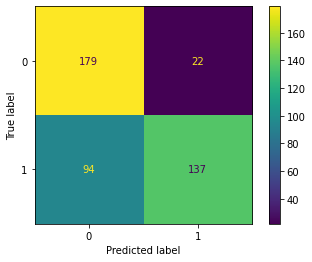

In [54]:
# Create directory to save models
rt_sv_dir = '/content/models'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)

# Run each split
for RUN in range(NUM_shuf):
  MERGM = build_model()

  MERGM.compile(
      optimizer =  keras.optimizers.Adam(lr=0.01),
      loss = 'BinaryCrossentropy',
      metrics=['AUC'])

  tfeatures = DATA_train [RUN]['MFCCS'][:]
  textra    = DATA_train[RUN]['EXTRA'][:]
  timgs     = DATA_train[RUN]['MEL'][:]
  labels    = DATA_train[RUN]['LABELS'][:]

  test_features= DATA_test[RUN]['MFCCS'][ :]
  test_extra   = DATA_test[RUN]['EXTRA'][:]
  test_imgs    = DATA_test[RUN]['MEL'][ :]
  test_labels  = DATA_test[RUN]['LABELS'][ :]
                                        
  val_features= DATA_val[RUN]['MFCCS'][ :]
  val_extra   = DATA_val[RUN]['EXTRA'][:]
  val_imgs    = DATA_val[RUN]['MEL'][  :]
  val_labels  = DATA_val[RUN]['LABELS'][ :]

  imgs_em      = TripleInputGenerator(tfeatures,timgs,textra,labels,batch_size=48,target_size=(64,64))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(64,64))
  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=48,target_size=(64,64))


  evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
  checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=True)
  os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
  MERGM.fit_generator(
                  imgs_em,
                  epochs=20,
                  validation_data=VAL, 
                  verbose=2, 
                  callbacks=[evaluator, checkpointer])

  MERGM_Record1 = MERGM.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = MERGM.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')
  from sklearn.metrics import ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_predictions(y_test[:len(y_preds_test)], y_preds_test>0.5)
  plt.savefig('ConfusionMatrix.png')
  plt.show()

---
# 4-Model Visualization
---

0
Num_samples: 432
acc:  0.7662037037037037


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


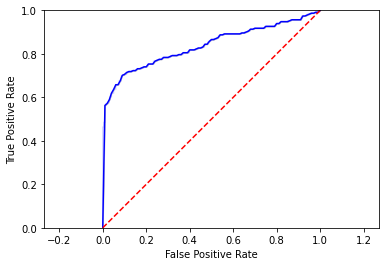

In [55]:


# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: '/content/models/0/012--0.476--0.352.hdf5'
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(1):
  print(iii)
  test_features= DATA_test[RUN]['MFCCS'][:]
  test_extra   = DATA_test[RUN]['EXTRA'][:]
  test_imgs    = DATA_test[RUN]['MEL'][:]
  test_labels  = DATA_test[RUN]['LABELS'][:]
  
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(64,64))

  model = keras.models.load_model(models[iii])
  y_score = model.predict(TEST)
  fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
  print('Num_samples:', len(y_score))

  print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

  plt.plot(fpr, tpr, 'b', alpha=0.15)
  tpr = interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('roc_curve.png')
plt.show()

